In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import Counter
import numpy as np
import re
if torch.cuda.is_available():
    print("CUDA is available. GPU details:")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Memory Allocated: {torch.cuda.memory_allocated(0)/1024**3:.2f} GB")
    print(f"Memory Cached: {torch.cuda.memory_reserved(0)/1024**3:.2f} GB")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available. GPU details:
Device Name: NVIDIA GeForce RTX 3060 Laptop GPU
Memory Allocated: 0.00 GB
Memory Cached: 0.00 GB


In [4]:
def preprocess_text(text):
    # Lowercase and remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())
    # Tokenize
    words = text.split()
    return words


# Load the text data
with open('final_processed_wikipedia_all_pages_contents.txt', 'r', encoding='utf-8') as file:
    text_data = file.read()

# Preprocess the data
words = preprocess_text(text_data)

In [5]:
def build_vocab_and_cooccurrence(words, window_size=4):
    word_counts = Counter(words)
    vocab = {word: i for i, (word, _) in enumerate(word_counts.items())}
    vocab_size = len(vocab)

    cooccurrence_matrix = np.zeros((vocab_size, vocab_size))

    for i, word in enumerate(words):
        word_idx = vocab[word]
        for j in range(max(i - window_size, 0), min(i + window_size + 1, len(words))):
            if i != j:
                context_word_idx = vocab[words[j]]
                cooccurrence_matrix[word_idx][context_word_idx] += 1

    return vocab, cooccurrence_matrix


vocab, cooccurrence_matrix = build_vocab_and_cooccurrence(words)

In [7]:
class GloVeModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(GloVeModel, self).__init__()
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.word_biases = nn.Embedding(vocab_size, 1)
        self.context_biases = nn.Embedding(vocab_size, 1)

        # Initialize embeddings and biases
        nn.init.xavier_uniform_(self.word_embeddings.weight)
        nn.init.xavier_uniform_(self.context_embeddings.weight)
        nn.init.constant_(self.word_biases.weight, 0.0)
        nn.init.constant_(self.context_biases.weight, 0.0)

    def forward(self, word_indices, context_indices):
        word_vectors = self.word_embeddings(word_indices)
        context_vectors = self.context_embeddings(context_indices)
        word_bias = self.word_biases(word_indices).squeeze()
        context_bias = self.context_biases(context_indices).squeeze()

        dot_product = torch.sum(word_vectors * context_vectors, dim=1)
        return dot_product + word_bias + context_bias


def loss_fn(predictions, targets, weights):
    return torch.mean(weights * (predictions - torch.log(targets + 1e-10)) ** 2)

In [8]:
def train_glove_model(vocab_size, cooccurrence_matrix, embedding_dim=50, epochs=100, learning_rate=0.05):
    model = GloVeModel(vocab_size, embedding_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    word_indices, context_indices = np.nonzero(cooccurrence_matrix)
    cooccurrence_values = cooccurrence_matrix[word_indices, context_indices]
    weights = np.minimum(cooccurrence_values / 100.0, 1.0)

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        word_indices_tensor = torch.tensor(word_indices, dtype=torch.long)
        context_indices_tensor = torch.tensor(
            context_indices, dtype=torch.long)
        targets_tensor = torch.tensor(cooccurrence_values, dtype=torch.float32)
        weights_tensor = torch.tensor(weights, dtype=torch.float32)

        predictions = model(word_indices_tensor, context_indices_tensor)
        loss = loss_fn(predictions, targets_tensor, weights_tensor)

        loss.backward()
        optimizer.step()

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

    return model


# nvidia-smi

# Train the GloVe model
embedding_dim = 50  # You can adjust this
vocab_size = len(vocab)
glove_model = train_glove_model(vocab_size, cooccurrence_matrix, embedding_dim)

Epoch 10/100, Loss: 0.041281066834926605
Epoch 20/100, Loss: 0.016834886744618416
Epoch 30/100, Loss: 0.010105960071086884
Epoch 40/100, Loss: 0.007297255098819733
Epoch 50/100, Loss: 0.005780924577265978
Epoch 60/100, Loss: 0.004810819402337074
Epoch 70/100, Loss: 0.004256190732121468
Epoch 80/100, Loss: 0.003865187056362629
Epoch 90/100, Loss: 0.0035715829581022263
Epoch 100/100, Loss: 0.003335047047585249


In [9]:
def save_embeddings(model, vocab, filepath="glove_embeddings_wiki.txt"):
    word_embeddings = model.word_embeddings.weight.data.numpy()
    with open(filepath, 'w', encoding='utf-8') as f:
        for word, idx in vocab.items():
            embedding = ' '.join(map(str, word_embeddings[idx]))
            f.write(f"{word} {embedding}\n")


save_embeddings(glove_model, vocab)

In [10]:
# Save the GloVe model
torch.save({
    'model_state_dict': glove_model.state_dict(),
    'vocab': vocab,
    'embedding_dim': embedding_dim
}, 'glove_model_wiki.pth')

print("Model saved successfully!")


Model saved successfully!


In [11]:
# Load the GloVe model
checkpoint = torch.load('glove_model_wiki.pth')

# Re-instantiate the GloVe model
loaded_model = GloVeModel(len(checkpoint['vocab']), checkpoint['embedding_dim'])
loaded_model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
loaded_model.eval()

print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Extract the embeddings from the trained model
# word_embeddings = glove_model.word_embeddings.weight.data.numpy()

# # Use t-SNE to reduce dimensions to 2D for visualization
# tsne = TSNE(n_components=2, random_state=0)
# word_embeddings_2d = tsne.fit_transform(word_embeddings)

# # Plot the embeddings
# plt.figure(figsize=(10, 10))
# for word, idx in vocab.items():
#     plt.scatter(word_embeddings_2d[idx, 0], word_embeddings_2d[idx, 1])
#     plt.text(word_embeddings_2d[idx, 0], word_embeddings_2d[idx, 1], word, fontsize=9)
# plt.show()


In [13]:
import numpy as np

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Example word pairs (replace with actual Igala word pairs)
word_pairs = [("enekele", "onobule")]

for word1, word2 in word_pairs:
    if word1 in vocab and word2 in vocab:
        vec1 = glove_model.word_embeddings.weight.data[vocab[word1]].numpy()
        vec2 = glove_model.word_embeddings.weight.data[vocab[word2]].numpy()
        similarity = cosine_similarity(vec1, vec2)
        print(f"Cosine similarity between '{word1}' and '{word2}': {similarity:.4f}")
    else:
        print(f"Words '{word1}' or '{word2}' not found in the vocabulary.")


Cosine similarity between 'enekele' and 'onobule': 0.8275


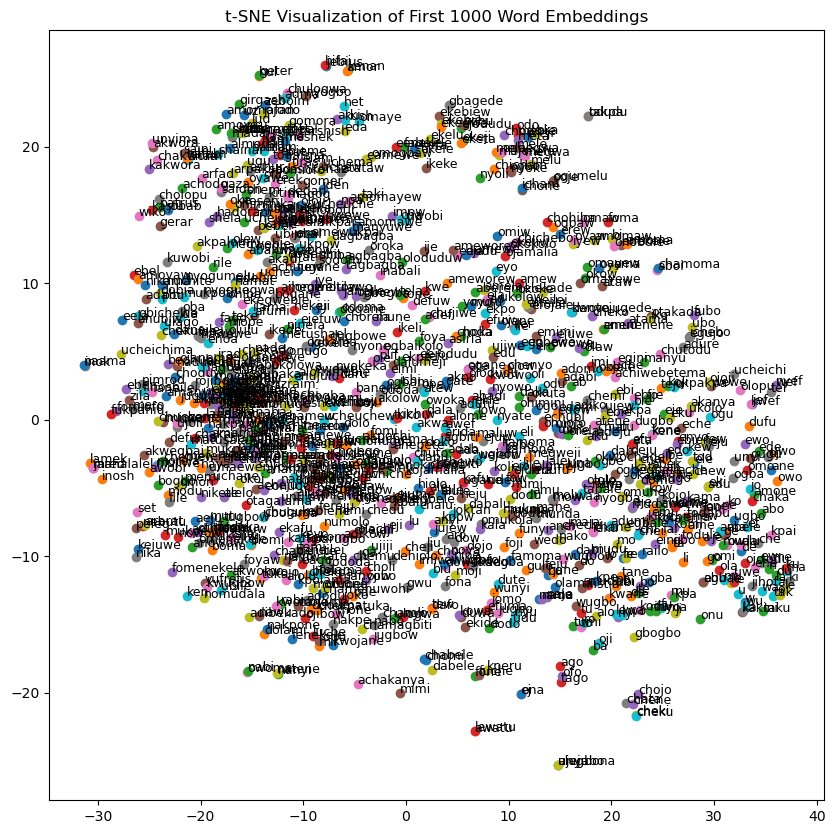

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract the embeddings from the trained model
word_embeddings = glove_model.word_embeddings.weight.data.numpy()

# Limit to the first 1000 embeddings
word_embeddings_subset = word_embeddings[:1000]
vocab_subset = {word: idx for word, idx in list(vocab.items())[:1000]}

# Use t-SNE to reduce dimensions to 2D for visualization
tsne = TSNE(n_components=2, random_state=0)
word_embeddings_2d = tsne.fit_transform(word_embeddings_subset)

# Plot the embeddings
plt.figure(figsize=(10, 10))
for word, idx in vocab_subset.items():
    plt.scatter(word_embeddings_2d[idx, 0], word_embeddings_2d[idx, 1])
    plt.text(word_embeddings_2d[idx, 0], word_embeddings_2d[idx, 1], word, fontsize=9)
plt.title('t-SNE Visualization of First 1000 Word Embeddings')
plt.show()


In [15]:
import numpy as np

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Example word pairs (replace with actual Igala word pairs)
word_pairs = [("efuma", "chone")]

for word1, word2 in word_pairs:
    if word1 in vocab and word2 in vocab:
        vec1 = glove_model.word_embeddings.weight.data[vocab[word1]].numpy()
        vec2 = glove_model.word_embeddings.weight.data[vocab[word2]].numpy()
        similarity = cosine_similarity(vec1, vec2)
        print(f"Cosine similarity between '{word1}' and '{word2}': {similarity:.4f}")
    else:
        print(f"Words '{word1}' or '{word2}' not found in the vocabulary.")


Cosine similarity between 'efuma' and 'chone': 0.7467


In [18]:
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE

# Assume word_embeddings_subset and vocab_subset are already defined
# as in the previous steps

# Perform t-SNE on the embeddings
tsne = TSNE(n_components=2, random_state=0)
word_embeddings_2d = tsne.fit_transform(word_embeddings_subset)

# Prepare the data for Plotly
words = list(vocab_subset.keys())
df = pd.DataFrame(word_embeddings_2d, columns=['x', 'y'])
df['word'] = words

# Create the interactive plot
fig = px.scatter(df, x='x', y='y', text='word')
fig.update_traces(textposition='top center', marker=dict(size=8, opacity=0.6))
fig.update_layout(title='t-SNE Visualization of First 1000 Word Embeddings (Interactive)',
                  xaxis_title='t-SNE dimension 1',
                  yaxis_title='t-SNE dimension 2')

# Show the plot
fig.show()


In [17]:
pip install plotly

   ---------------------------------------- 0.0/17.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/17.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/17.3 MB 1.3 MB/s eta 0:00:13
    --------------------------------------- 0.2/17.3 MB 2.9 MB/s eta 0:00:06
    --------------------------------------- 0.2/17.3 MB 2.9 MB/s eta 0:00:06
    --------------------------------------- 0.4/17.3 MB 1.9 MB/s eta 0:00:10
   - -------------------------------------- 0.5/17.3 MB 2.1 MB/s eta 0:00:09
   - -------------------------------------- 0.6/17.3 MB 2.0 MB/s eta 0:00:09
   - -------------------------------------- 0.7/17.3 MB 2.2 MB/s eta 0:00:08
   -- ------------------------------------- 1.0/17.3 MB 2.5 MB/s eta 0:00:07
   --- ------------------------------------ 1.3/17.3 MB 3.1 MB/s eta 0:00:06
   --- ------------------------------------ 1.4/17.3 MB 3.1 MB/s eta 0:00:06
   --- ------------------------------------ 1.5/17.3 MB 2.9 MB/s eta 0:00:06
   --- ------

In [19]:
import numpy as np

def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# Example word pairs (replace with actual Igala word pairs)
word_pairs = [("odudu", "takpa")]

for word1, word2 in word_pairs:
    if word1 in vocab and word2 in vocab:
        vec1 = glove_model.word_embeddings.weight.data[vocab[word1]].numpy()
        vec2 = glove_model.word_embeddings.weight.data[vocab[word2]].numpy()
        similarity = cosine_similarity(vec1, vec2)
        print(f"Cosine similarity between '{word1}' and '{word2}': {similarity:.4f}")
    else:
        print(f"Words '{word1}' or '{word2}' not found in the vocabulary.")

Cosine similarity between 'odudu' and 'takpa': 0.8117


In [ ]:
# Cosine similarity between 'ka' and 'kakini': 0.8932

In [20]:
import torch

# Load the saved GloVe model
checkpoint = torch.load('glove_model.pth')
glove_model = GloVeModel(len(checkpoint['vocab']), checkpoint['embedding_dim'])
glove_model.load_state_dict(checkpoint['model_state_dict'])
glove_model.eval()

# Access the vocabulary
vocab = checkpoint['vocab']

In [21]:
import numpy as np


def cosine_similarity(vec1, vec2):
    """Compute the cosine similarity between two vectors."""
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [35]:
def find_similar_words(target_word, vocab, glove_model, top_n=5):
    """Find the top_n words most similar to the target_word."""
    if target_word not in vocab:
        return f"Word '{target_word}' not found in the vocabulary."

    target_idx = vocab[target_word]
    target_vec = glove_model.word_embeddings.weight.data[target_idx].numpy()

    similarities = {}

    for word, idx in vocab.items():
        if word != target_word:
            word_vec = glove_model.word_embeddings.weight.data[idx].numpy()
            similarity = cosine_similarity(target_vec, word_vec)
            similarities[word] = similarity

    # Sort the words by similarity and return the top_n
    sorted_similarities = sorted(
        similarities.items(), key=lambda item: item[1], reverse=True)
    return sorted_similarities[:top_n]


# Example usage
similar_words = find_similar_words('yoyo', vocab, glove_model, top_n=5)
for word, similarity in similar_words:
    print(f"Word: {word}, Similarity: {similarity:.4f}")

Word: mufu, Similarity: 0.6906
Word: kewo, Similarity: 0.6399
Word: kpuna, Similarity: 0.6261
Word: ugbemi, Similarity: 0.6190
Word: jowoma, Similarity: 0.6138
